In [28]:
from openchart import NSEData
nse=NSEData()

In [29]:
nse.download()

NSE data shape: (3038, 4)
NFO data shape: (77752, 4)
NSE and NFO data downloaded successfully.


In [30]:
import datetime

end_date= datetime.datetime.now()
start_date=end_date-datetime.timedelta(days=30)

data=nse.historical(symbol="RELIANCE",exchange='NSE',start=start_date,end=end_date,interval='15m')

data



,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-06-12 10:59:59,1448.8,1449.0,1446.8,1448.2,44064
2025-06-12 11:14:59,1448.2,1450.6,1448.0,1449.2,149752
2025-06-12 11:29:59,1449.2,1451.7,1448.1,1451.4,178594
2025-06-12 11:44:59,1451.6,1451.6,1448.6,1450.9,232378
2025-06-12 11:59:59,1450.5,1450.8,1448.9,1449.3,127421
...,...,...,...,...,...
2025-07-11 14:14:59,1494.4,1494.9,1492.2,1494.1,227197
2025-07-11 14:29:57,1494.1,1494.1,1492.6,1492.6,197493
2025-07-11 14:44:55,1492.6,1494.5,1492.3,1493.4,297885


In [31]:
from openchart import NSEData
import datetime

# Initialize NSEData
nse = NSEData()
nse.download()

# Define the time range
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)

# Define 10 stock symbols
symbols = ["RELIANCE", "TCS", "INFY", "HDFCBANK", "ICICIBANK", 
           "KOTAKBANK", "ITC", "LT", "SBIN", "AXISBANK"]

# Define intervals you want
intervals = {
    "5m": "5m",
    "15m": "15m",
    "1h": "1h"
}

# Dictionary to hold data
all_data = {}

# Loop through each stock and each interval
for symbol in symbols:
    all_data[symbol] = {}
    for label, interval in intervals.items():
        try:
            df = nse.historical(symbol=symbol, exchange='NSE',
                                start=start_date, end=end_date, interval=interval)
            all_data[symbol][label] = df
            print(f"Fetched {label} data for {symbol}")
        except Exception as e:
            print(f"Error fetching {label} data for {symbol}: {e}")


NSE data shape: (3038, 4)
NFO data shape: (77752, 4)
NSE and NFO data downloaded successfully.
Fetched 5m data for RELIANCE
Fetched 15m data for RELIANCE
Fetched 1h data for RELIANCE
Fetched 5m data for TCS
Fetched 15m data for TCS
Fetched 1h data for TCS
Fetched 5m data for INFY
Fetched 15m data for INFY
Fetched 1h data for INFY
Fetched 5m data for HDFCBANK
Fetched 15m data for HDFCBANK
Fetched 1h data for HDFCBANK
Fetched 5m data for ICICIBANK
Fetched 15m data for ICICIBANK
Fetched 1h data for ICICIBANK
Fetched 5m data for KOTAKBANK
Fetched 15m data for KOTAKBANK
Fetched 1h data for KOTAKBANK
Fetched 5m data for ITC
Fetched 15m data for ITC
Fetched 1h data for ITC
Fetched 5m data for LT
Fetched 15m data for LT
Fetched 1h data for LT
Fetched 5m data for SBIN
Fetched 15m data for SBIN
Fetched 1h data for SBIN
Fetched 5m data for AXISBANK
Fetched 15m data for AXISBANK
Fetched 1h data for AXISBANK


In [32]:
import numpy as np
import pandas as pd
import math

def calculate_angle(series, length=5):
    """Calculate EMA slope in degrees over `length` periods"""
    radians = np.arctan((series - series.shift(length)) / length)
    degrees = np.degrees(radians)
    return degrees


In [33]:
def is_valid_bullish_candle(row):
    body = abs(row['close'] - row['open'])
    upper_wick = row['high'] - max(row['close'], row['open'])
    lower_wick = min(row['close'], row['open']) - row['low']
    if body == 0:
        return False
    upper_ratio = upper_wick / body
    lower_ratio = lower_wick / body
    return (
        (0.05 <= upper_ratio <= 0.10) or
        (upper_wick <= 0.01 * row['close']) or
        (lower_wick >= 2 * body and upper_wick < body)
    )

def is_valid_bearish_candle(row):
    body = abs(row['close'] - row['open'])
    upper_wick = row['high'] - max(row['open'], row['close'])
    lower_wick = min(row['open'], row['close']) - row['low']
    if body == 0:
        return False
    lower_ratio = lower_wick / body
    upper_ratio = upper_wick / body
    return (
        (0.05 <= lower_ratio <= 0.20) or
        (lower_wick <= 0.01 * row['close']) or
        (upper_wick >= 2 * body and lower_wick < body)
    )
def apply_strategy(df):
    df = df.copy()
    df['EMA9'] = df['close'].ewm(span=9).mean()
    df['EMA15'] = df['close'].ewm(span=15).mean()
    
    df['Angle9'] = calculate_angle(df['EMA9'])
    df['Angle15'] = calculate_angle(df['EMA15'])
    
    df['Signal'] = None
    trades = []

    for i in range(15, len(df)-1):  # skip early EMA warm-up
        candle = df.iloc[i]
        next_candle = df.iloc[i+1]

        ema_min = min(candle['EMA9'], candle['EMA15'])
        ema_max = max(candle['EMA9'], candle['EMA15'])

        price_touch = ema_min <= candle['low'] <= ema_max or ema_min <= candle['high'] <= ema_max

        long_condition = (
            price_touch and
            candle['close'] > candle['open'] and
            candle['Angle9'] > 30 and
            candle['Angle15'] > 30
        )
        short_condition = (
            price_touch and
            candle['close'] < candle['open'] and
            candle['Angle9'] < -30 and
            candle['Angle15'] < -30
        )

        if long_condition:
            entry = next_candle['open']
            sl = candle['low']
            target = entry + 2 * (entry - sl)
            trades.append({'type': 'LONG', 'entry': entry, 'sl': sl, 'target': target, 'index': i+1})
            df.at[df.index[i+1], 'Signal'] = 'BUY'
        elif short_condition:
            entry = next_candle['open']
            sl = candle['high']
            target = entry - 2 * (sl - entry)
            trades.append({'type': 'SHORT', 'entry': entry, 'sl': sl, 'target': target, 'index': i+1})
            df.at[df.index[i+1], 'Signal'] = 'SELL'

    return df, trades


In [34]:
# Store data and trades
all_data = {}
all_trades = {}

for symbol in symbols:
    all_data[symbol] = {}
    all_trades[symbol] = {}
    for label, interval in intervals.items():
        try:
            df = nse.historical(symbol=symbol, exchange='NSE',
                                start=start_date, end=end_date, interval=interval)
            
            # Clean up: lowercase column names
            df.columns = [col.lower() for col in df.columns]

            # Apply Strategy
            processed_df, trades = apply_strategy(df)
            all_data[symbol][label] = processed_df
            all_trades[symbol][label] = trades

            print(f"✅ Strategy applied on {symbol} [{label}] — Trades found: {len(trades)}")

        except Exception as e:
            print(f"❌ Error on {symbol} [{label}]: {e}")


✅ Strategy applied on RELIANCE [5m] — Trades found: 5
✅ Strategy applied on RELIANCE [15m] — Trades found: 8
✅ Strategy applied on RELIANCE [1h] — Trades found: 1
✅ Strategy applied on TCS [5m] — Trades found: 46
✅ Strategy applied on TCS [15m] — Trades found: 32
✅ Strategy applied on TCS [1h] — Trades found: 9
✅ Strategy applied on INFY [5m] — Trades found: 8
✅ Strategy applied on INFY [15m] — Trades found: 12
✅ Strategy applied on INFY [1h] — Trades found: 10
✅ Strategy applied on HDFCBANK [5m] — Trades found: 13
✅ Strategy applied on HDFCBANK [15m] — Trades found: 11
✅ Strategy applied on HDFCBANK [1h] — Trades found: 4
✅ Strategy applied on ICICIBANK [5m] — Trades found: 2
✅ Strategy applied on ICICIBANK [15m] — Trades found: 5
✅ Strategy applied on ICICIBANK [1h] — Trades found: 8
✅ Strategy applied on KOTAKBANK [5m] — Trades found: 16
✅ Strategy applied on KOTAKBANK [15m] — Trades found: 30
✅ Strategy applied on KOTAKBANK [1h] — Trades found: 10
✅ Strategy applied on ITC [5m] — T

In [35]:
for t in all_trades['LT']['15m']:
    print(t)


{'type': 'SHORT', 'entry': 24673.4, 'sl': 24730.35, 'target': 24559.500000000007, 'index': 18}
{'type': 'SHORT', 'entry': 24544.6, 'sl': 24567.6, 'target': 24498.6, 'index': 30}
{'type': 'SHORT', 'entry': 24539.2, 'sl': 24572.4, 'target': 24472.8, 'index': 31}
{'type': 'SHORT', 'entry': 24533.75, 'sl': 24566.75, 'target': 24467.75, 'index': 32}
{'type': 'SHORT', 'entry': 24513.65, 'sl': 24532.0, 'target': 24476.950000000004, 'index': 38}
{'type': 'SHORT', 'entry': 24379.95, 'sl': 24497.65, 'target': 24144.55, 'index': 46}
{'type': 'SHORT', 'entry': 24494.4, 'sl': 24522.25, 'target': 24438.700000000004, 'index': 50}
{'type': 'LONG', 'entry': 24802.5, 'sl': 24715.85, 'target': 24975.800000000003, 'index': 71}
{'type': 'LONG', 'entry': 24795.25, 'sl': 24789.7, 'target': 24806.35, 'index': 79}
{'type': 'SHORT', 'entry': 24721.25, 'sl': 24760.55, 'target': 24642.65, 'index': 83}
{'type': 'SHORT', 'entry': 24718.9, 'sl': 24738.05, 'target': 24680.600000000006, 'index': 88}
{'type': 'SHORT', 

In [36]:
def evaluate_trades(df, trades):
    wins = 0
    total = len(trades)

    for trade in trades:
        idx = trade['index']
        entry_price = trade['entry']
        sl = trade['sl']
        target = trade['target']
        direction = trade['type']
        
        # Loop through candles AFTER entry
        for i in range(idx + 1, len(df)):
            row = df.iloc[i]
            high = row['high']
            low = row['low']

            if direction == 'LONG':
                if low <= sl:
                    break  # SL hit first
                elif high >= target:
                    wins += 1
                    break  # TP hit first

            elif direction == 'SHORT':
                if high >= sl:
                    break  # SL hit first
                elif low <= target:
                    wins += 1
                    break  # TP hit first

    win_rate = (wins / total * 100) if total > 0 else 0
    return wins, total, round(win_rate, 2)


In [37]:
results = []

for symbol in all_trades:
    for tf in all_trades[symbol]:
        df = all_data[symbol].get(tf)
        trades = all_trades[symbol].get(tf)

        if df is not None and trades:
            wins, total, winrate = evaluate_trades(df, trades)
            results.append((symbol, tf, total, wins, winrate))


In [38]:
print(f"{'Symbol':<12} {'Timeframe':<8} {'Trades':<7} {'Wins':<5} {'Winrate (%)':<12}")
print("-" * 50)
for symbol, tf, total, wins, winrate in results:
    print(f"{symbol:<12} {tf:<8} {total:<7} {wins:<5} {winrate:<12}")


Symbol       Timeframe Trades  Wins  Winrate (%) 
--------------------------------------------------
RELIANCE     5m       5       3     60.0        
RELIANCE     15m      8       2     25.0        
RELIANCE     1h       1       0     0.0         
TCS          5m       46      19    41.3        
TCS          15m      32      10    31.25       
TCS          1h       9       5     55.56       
INFY         5m       8       3     37.5        
INFY         15m      12      2     16.67       
INFY         1h       10      2     20.0        
HDFCBANK     5m       13      4     30.77       
HDFCBANK     15m      11      6     54.55       
HDFCBANK     1h       4       2     50.0        
ICICIBANK    5m       2       0     0.0         
ICICIBANK    15m      5       1     20.0        
ICICIBANK    1h       8       0     0.0         
KOTAKBANK    5m       16      7     43.75       
KOTAKBANK    15m      30      6     20.0        
KOTAKBANK    1h       10      3     30.0        
LT           5m  

In [40]:
bullish_params = {
    'upper_wick_pct': [0.05, 0.06, 0.07, 0.08, 0.09, 0.10],
    'ema_angle_min': [30, 35, 40, 45],
    'rr_ratio': [1.5, 2, 2.5, 3]
}

bearish_params = {
    'lower_wick_pct': [0.05, 0.10, 0.15, 0.20],
    'ema_angle_max': [-30, -35, -40, -45],
    'rr_ratio': [1.5, 2, 2.5, 3]
}


In [41]:
def run_strategy_grid(df, wick_pct, ema_angle, rr_ratio, direction='bullish'):
    df = df.copy()
    df['EMA9'] = df['close'].ewm(span=9).mean()
    df['EMA15'] = df['close'].ewm(span=15).mean()
    df['Angle9'] = calculate_angle(df['EMA9'])
    df['Angle15'] = calculate_angle(df['EMA15'])
    
    trades = []

    for i in range(15, len(df) - 1):
        c = df.iloc[i]
        next_c = df.iloc[i + 1]
        body = abs(c['close'] - c['open'])
        range_ = c['high'] - c['low']
        if body == 0 or range_ == 0:
            continue
        ema_gap = abs(c['EMA9'] - c['EMA15'])

        # Zone check
        ema_min = min(c['EMA9'], c['EMA15'])
        ema_max = max(c['EMA9'], c['EMA15'])
        in_zone = ema_min <= c['low'] <= ema_max or ema_min <= c['high'] <= ema_max

        if direction == 'bullish' and c['close'] > c['open']:
            upper_wick = c['high'] - c['close']
            if (upper_wick / body <= wick_pct and
                c['Angle9'] > ema_angle and c['Angle15'] > ema_angle and
                ema_gap > 0.001 * c['close'] and in_zone):
                entry = next_c['open']
                sl = c['low']
                target = entry + rr_ratio * (entry - sl)
                trades.append({'type': 'LONG', 'entry': entry, 'sl': sl, 'target': target, 'index': i+1})

        elif direction == 'bearish' and c['close'] < c['open']:
            lower_wick = c['close'] - c['low']
            if (lower_wick / body <= wick_pct and
                c['Angle9'] < ema_angle and c['Angle15'] < ema_angle and
                ema_gap > 0.001 * c['close'] and in_zone):
                entry = next_c['open']
                sl = c['high']
                target = entry - rr_ratio * (sl - entry)
                trades.append({'type': 'SHORT', 'entry': entry, 'sl': sl, 'target': target, 'index': i+1})

    return trades


In [42]:
def grid_search_strategy(df, direction='bullish'):
    results = []

    param_grid = bullish_params if direction == 'bullish' else bearish_params
    wick_key = 'upper_wick_pct' if direction == 'bullish' else 'lower_wick_pct'
    angle_key = 'ema_angle_min' if direction == 'bullish' else 'ema_angle_max'

    for wick in param_grid[wick_key]:
        for angle in param_grid[angle_key]:
            for rr in param_grid['rr_ratio']:
                trades = run_strategy_grid(df, wick, angle, rr, direction)
                wins, total, winrate = evaluate_trades(df, trades)
                results.append({
                    'wick_pct': wick,
                    'ema_angle': angle,
                    'rr_ratio': rr,
                    'trades': total,
                    'wins': wins,
                    'winrate': winrate
                })
    return pd.DataFrame(results)


In [44]:
def get_best_config(df, direction):
    results = grid_search_strategy(df, direction)
    if not results.empty:
        best = results.sort_values('winrate', ascending=False).iloc[0]
        return best.to_dict()
    return None


In [45]:
final_results = []

for symbol in all_data:
    for tf in all_data[symbol]:
        df = all_data[symbol][tf]
        if df is None or df.empty:
            continue

        print(f"📊 Optimizing {symbol} [{tf}]...")

        # Bullish
        best_bullish = get_best_config(df, direction='bullish')
        if best_bullish:
            best_bullish.update({
                'symbol': symbol,
                'timeframe': tf,
                'direction': 'bullish'
            })
            final_results.append(best_bullish)

        # Bearish
        best_bearish = get_best_config(df, direction='bearish')
        if best_bearish:
            best_bearish.update({
                'symbol': symbol,
                'timeframe': tf,
                'direction': 'bearish'
            })
            final_results.append(best_bearish)


📊 Optimizing RELIANCE [5m]...
📊 Optimizing RELIANCE [15m]...
📊 Optimizing RELIANCE [1h]...
📊 Optimizing TCS [5m]...
📊 Optimizing TCS [15m]...
📊 Optimizing TCS [1h]...
📊 Optimizing INFY [5m]...
📊 Optimizing INFY [15m]...
📊 Optimizing INFY [1h]...
📊 Optimizing HDFCBANK [5m]...
📊 Optimizing HDFCBANK [15m]...
📊 Optimizing HDFCBANK [1h]...
📊 Optimizing ICICIBANK [5m]...
📊 Optimizing ICICIBANK [15m]...
📊 Optimizing ICICIBANK [1h]...
📊 Optimizing KOTAKBANK [5m]...
📊 Optimizing KOTAKBANK [15m]...
📊 Optimizing KOTAKBANK [1h]...
📊 Optimizing ITC [5m]...
📊 Optimizing ITC [15m]...
📊 Optimizing ITC [1h]...
📊 Optimizing LT [5m]...
📊 Optimizing LT [15m]...
📊 Optimizing LT [1h]...
📊 Optimizing SBIN [5m]...
📊 Optimizing SBIN [15m]...
📊 Optimizing SBIN [1h]...
📊 Optimizing AXISBANK [5m]...
📊 Optimizing AXISBANK [15m]...
📊 Optimizing AXISBANK [1h]...


In [48]:
best_configs_df = pd.DataFrame(final_results)

# Show top winners
print("🔥 Best Overall Configs (sorted by winrate):")
print(best_configs_df.sort_values('winrate', ascending=False).head(10))

# Save to CSV 
best_configs_df.to_csv("best_trading_configs.csv", index=False)


🔥 Best Overall Configs (sorted by winrate):
    wick_pct  ema_angle  rr_ratio  trades  wins  winrate     symbol timeframe  \
30      0.05       30.0       1.5     2.0   2.0   100.00  KOTAKBANK        5m   
2       0.05       30.0       1.5     1.0   1.0   100.00   RELIANCE       15m   
57      0.15      -30.0       1.5     1.0   1.0   100.00   AXISBANK       15m   
20      0.10       45.0       1.5     1.0   1.0   100.00   HDFCBANK       15m   
6       0.05       30.0       1.5     1.0   1.0   100.00        TCS        5m   
7       0.05      -30.0       1.5     1.0   1.0   100.00        TCS        5m   
18      0.05       30.0       1.5     3.0   2.0    66.67   HDFCBANK        5m   
16      0.08       30.0       1.5     2.0   1.0    50.00       INFY        1h   
27      0.05      -30.0       1.5     2.0   1.0    50.00  ICICIBANK       15m   
14      0.08       30.0       1.5     2.0   1.0    50.00       INFY       15m   

   direction  
30   bullish  
2    bullish  
57   bearish  
20  

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, direction='bullish'):
    for rr in sorted(df['rr_ratio'].unique()):
        subset = df[(df['direction'] == direction) & (df['rr_ratio'] == rr)]
        pivot = subset.pivot_table(
            index='ema_angle',
            columns='wick_pct',
            values='winrate',
            aggfunc='mean'
        )

        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title(f'{direction.capitalize()} Winrate Heatmap (RR={rr})')
        plt.ylabel("EMA Angle")
        plt.xlabel("Wick %")
        plt.show()


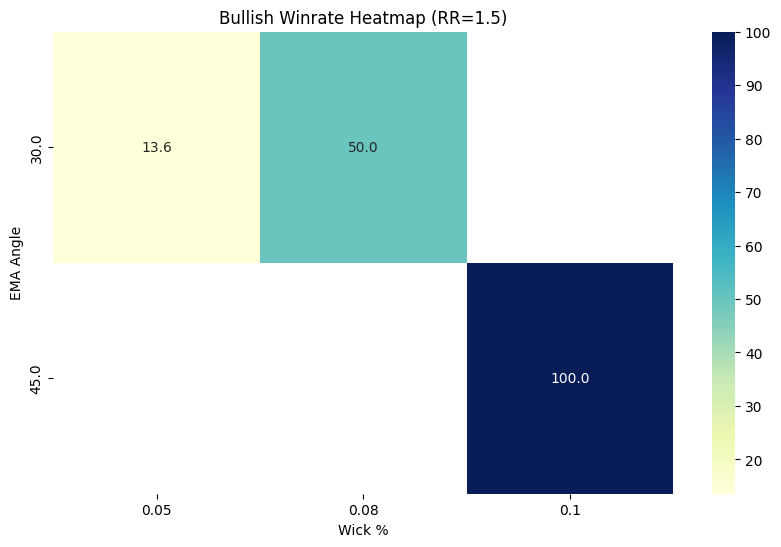

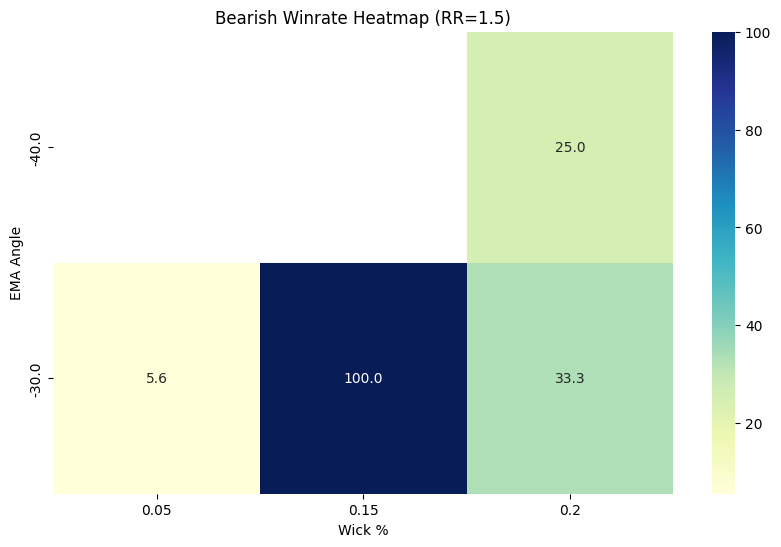

In [50]:
plot_heatmap(best_configs_df, direction='bullish')
plot_heatmap(best_configs_df, direction='bearish')


In [51]:
def plot_top_configs(df, direction='bullish', top_n=10):
    top = df[df['direction'] == direction].sort_values('winrate', ascending=False).head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='symbol', y='winrate', hue='timeframe', data=top)
    plt.title(f'Top {top_n} {direction.capitalize()} Configurations by Winrate')
    plt.ylim(0, 100)
    plt.ylabel("Winrate (%)")
    plt.show()


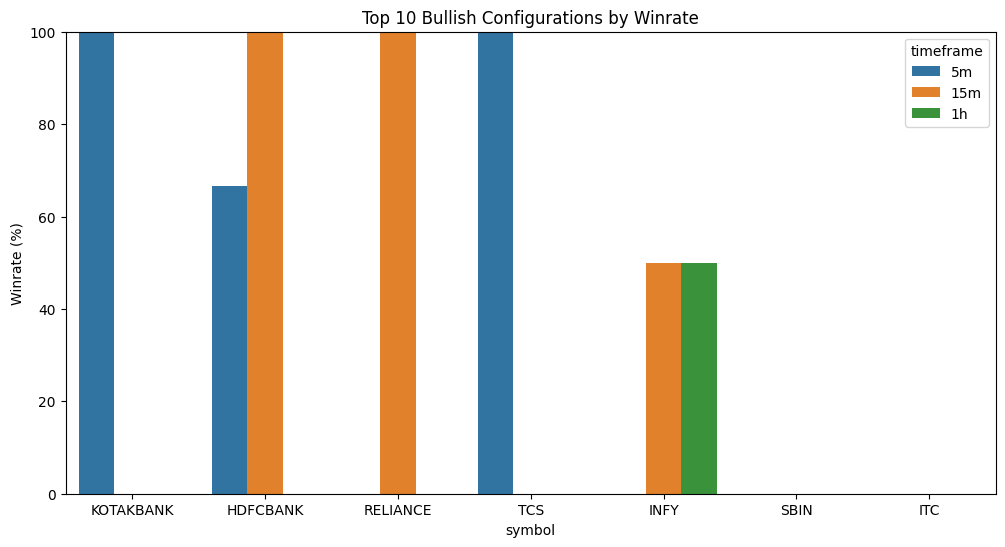

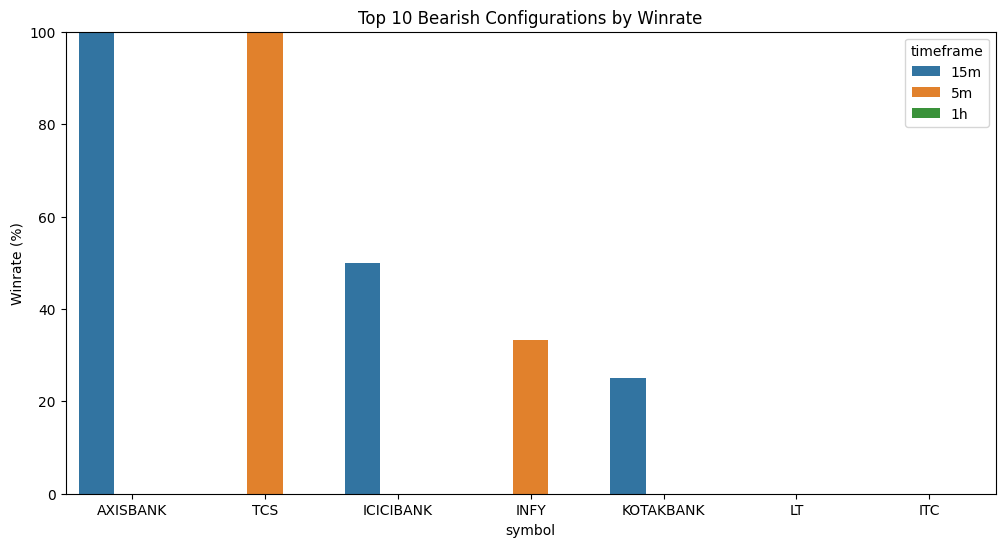

In [52]:
plot_top_configs(best_configs_df, 'bullish')
plot_top_configs(best_configs_df, 'bearish')
